In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import keras.utils as ku



In [10]:

# Set device for TensorFlow
device = "/device:CPU:0"

In [11]:
# Data directories
train_dir = "C:/Users/Shakthivel/OneDrive/Documents/Christ/3'rd Sem/SPD/Smart Waste/Data/train"
test_dir = "C:/Users/Shakthivel/OneDrive/Documents/Christ/3'rd Sem/SPD/Smart Waste/Data/test"

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

# Rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',  # Binary classification (biodegradable vs non-biodegradable)
    subset='training'  # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',  # Binary classification
    subset='validation'  # Use the validation subset
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'  # Binary classification
)


Found 1749 images belonging to 2 classes.
Found 437 images belonging to 2 classes.
Found 343 images belonging to 2 classes.


In [13]:
# Get class labels
labels = {0: 'biodegradable', 1: 'non_biodegradable'}
print("Class Labels:", labels)

Class Labels: {0: 'biodegradable', 1: 'non_biodegradable'}


In [14]:
# Transfer Learning with MobileNetV2
base_model = MobileNetV2(input_shape=(300, 300, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # Increased epochs for better training
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers after this point

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=10,  # Fine-tune for a few more epochs
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

C:\Users\Shakthivel\AppData\Local\Temp\ipykernel_11328\3528054110.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(300, 300, 3), include_top=False, weights='imagenet')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.6265 - loss: 0.6474 - val_accuracy: 0.8604 - val_loss: 0.3523
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8744 - loss: 0.3335 - val_accuracy: 0.9382 - val_loss: 0.1880
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9055 - loss: 0.2465 - val_accuracy: 0.9519 - val_loss: 0.1624
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.9141 - loss: 0.2518 - val_accuracy: 0.9474 - val_loss: 0.1479
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9194 - loss: 0.2000 - val_accuracy: 0.9474 - val_loss: 0.1478
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.9331 - loss: 0.1852 - val_accuracy: 0.9725 - val_loss: 0.1189
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.9306 - loss: 0.1818 - val_accuracy: 0.9565 - val_loss: 0.1172
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9318 - loss: 0.1705 - val_accuracy: 0.9542 - v

In [18]:
# Evaluate the model on test data
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Save the model
if not os.path.exists("weights"):
    os.makedirs("weights")

model.save("weights/modelnew.keras")

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("weights/modelnew.tflite", "wb") as f:
    f.write(tflite_model)

print("Model saved as 'weights/modelnew.keras' and 'weights/modelnew.tflite'")

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9227 - loss: 0.2235
Test Accuracy: 94.17%
INFO:tensorflow:Assets written to: C:\Users\SHAKTH~1\AppData\Local\Temp\tmpu4k4v63r\assets


INFO:tensorflow:Assets written to: C:\Users\SHAKTH~1\AppData\Local\Temp\tmpu4k4v63r\assets


Saved artifact at 'C:\Users\SHAKTH~1\AppData\Local\Temp\tmpu4k4v63r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2526771508880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774038896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774035728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774037488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526773952032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774044880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774043120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774045936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774034496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526774044176: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [19]:

# Function to predict and visualize results
def predict_and_visualize(image_path):
    img = ku.load_img(image_path, target_size=(300, 300))
    img = ku.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    prediction = model.predict(img[np.newaxis, ...])

    predicted_class = labels[int(np.round(prediction[0]))]
    print("Classified:", predicted_class)
    print("Probability:", np.max(prediction[0], axis=-1))

    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.title(f"Predicted: {predicted_class}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Classified: biodegradable
Probability: 0.0062729334


C:\Users\Shakthivel\AppData\Local\Temp\ipykernel_11328\2796276940.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = labels[int(np.round(prediction[0]))]


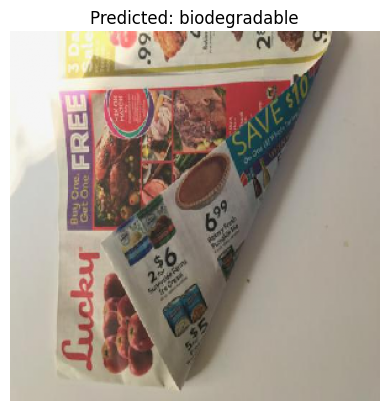

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Classified: non_biodegradable
Probability: 0.8967844


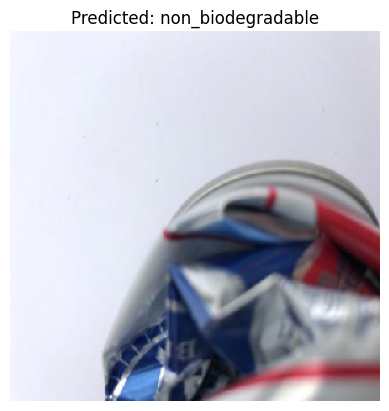

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Classified: non_biodegradable
Probability: 0.9996684


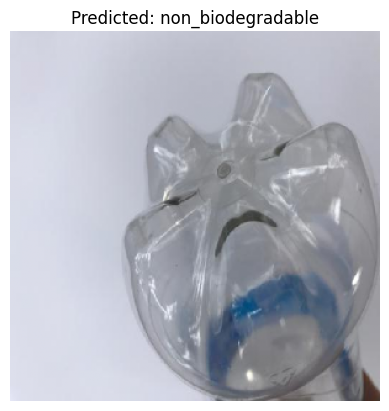

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Classified: biodegradable
Probability: 3.1180728e-06


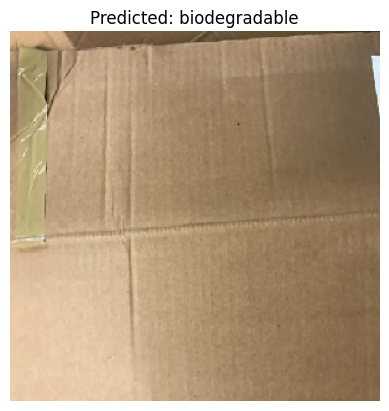

In [20]:
# Test predictions
test_images = [
    "C:/Users/Shakthivel/OneDrive/Documents/Christ/Project/Smart Waste/Data/test/biodegradable/paper522.jpg",  # Update with actual paths
    "C:/Users/Shakthivel/OneDrive/Documents/Christ/Project/Smart Waste/Data/test/non_biodegradable/metal386.jpg",
    "C:/Users/Shakthivel/OneDrive/Documents/Christ/Project/Smart Waste/Data/test/non_biodegradable/plastic430.jpg",
    "C:/Users/Shakthivel/OneDrive/Documents/Christ/Project/Smart Waste/Data/test/biodegradable/cardboard355.jpg"
]

for image_path in test_images:
    predict_and_visualize(image_path)